In [1]:
import numpy as np
import pandas as pd
import sys
import os
import pandas.core.indexes
sys.modules['pandas.indexes'] = pandas.core.indexes
import time
import yaml
import json
import matplotlib.pyplot as plt
import matplotlib

import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv3D, MaxPooling3D, BatchNormalization, Activation, Input, concatenate
from keras.callbacks import EarlyStopping
from keras.backend.tensorflow_backend import set_session
from keras.utils import multi_gpu_model
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid
from scipy.stats import iqr

sys.path.append("/home/esra/Desktop/git_repos/outcome-prediction/clinical parameter-based")
sys.path.append("/home/esra/Desktop/git_repos/outcome-prediction/TOF-based")
from helper import dataset, model
from imaging_predictive_models import imaging_dataset
from clinical_predictive_models import clinical_dataset, MLP
from multimodal_prediction_helper import multimodal_dataset
from keras_helper import EpochEvaluation


Using TensorFlow backend.


In [2]:
#### ENVIRONMENT AND SESSION SET UP ####################################################################
# set the environment variable
os.environ["KERAS_BACKEND"] = "tensorflow"
# Silence INFO logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [3]:
#### READ CONFIGURATION FILE ###########################################################################
def join(loader,node):
    seq = loader.construct_sequence(node)
    return ''.join(str(i) for i in seq)

yaml.add_constructor('!join',join)
cfg = yaml.load(open('config.yml', 'r'))

#### ASSIGN PATHS AND VARIABLES #########################################################################
dataset_name = cfg['dataset name']
img_splits_path = '/mnt/S_DRIVE/ML_Backup/Esra/TOF_based/data/1kplus_multimodal_imaging_train_val_test_set.pkl'
img_feat_splits_path = 'data/' + cfg['imaging dataset']['feature splits path']
img_models_path = cfg['imaging dataset']['models path']
img_params_folder = '../TOF-based/modeling_results/1kplus_multimodal/params/'
img_scores_folder = '../TOF-based/modeling_results/1kplus_multimodal/performance_scores/'
clin_splits_path = cfg['clinical dataset']['splits path']
clin_feat_splits_path = 'data/'+ cfg['clinical dataset']['feature splits path']
clin_models_path = cfg['clinical dataset']['models path']
clin_params_folder = '../clinical parameter-based/modeling_results/1kplus_multimodal/params/'
clin_scores_folder = '../clinical parameter-based/modeling_results/1kplus_multimodal/performance_scores/'
num_splits = cfg['number of runs']

In [ ]:
#### LOAD BOTH CLINICAL AND IMAGING DATA #################################################################
img_data = imaging_dataset(dataset_name)
img_sets = img_data.assign_train_val_test_sets(img_splits_path)
clin_data = clinical_dataset(dataset_name)
clin_sets = clin_data.assign_train_val_test_sets(clin_splits_path)
features = multimodal_dataset(dataset_name)
features.load_feature_sets(img_feat_splits_path, clin_feat_splits_path)

### 1. Variance in performace for different weight initializations, dropout choices etc.

In [4]:
# fix seed
np.random.seed(1)
tf.set_random_seed(2)
import random as rn
rn.seed(3)

In [5]:
model_names= ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']
sets = ['training', 'test']
iterables= [model_names, sets]
multiidx = pd.MultiIndex.from_product(iterables)

### CNN

In [6]:
medians_CNN = []
iqrs_CNN = []
AUC_CNN = []

for i in range(num_splits):
    AUC_trs_CNN, AUC_tes_CNN = np.loadtxt('../TOF-based/modeling_results/1kplus_multimodal/performance_scores/outer_loop_AUC_performance_over_100_runs_model_'+str(i+1)+'.csv', delimiter=",")

    medians_CNN.append([np.median(AUC_trs_CNN), np.median(AUC_tes_CNN)])
    iqrs_CNN.append([iqr(AUC_trs_CNN),  iqr(AUC_tes_CNN)])
    AUC_CNN.append(AUC_tes_CNN)
    
df_CNN = pd.DataFrame([],columns=multiidx,index = ['median','iqr'])
df_CNN.loc['median',:] = list(matplotlib.cbook.flatten(medians_CNN))
df_CNN.loc['iqr',:] = list(matplotlib.cbook.flatten(iqrs_CNN))

In [7]:
df_CNN

Model 1                Model 2             Model 3             \
         training       test    training       test training       test   
median   0.967652   0.617284    0.997037   0.757407        1   0.683333   
iqr     0.0418769  0.0503086  0.00402354  0.0262346        0  0.0324074   

          Model 4             Model 5            
         training      test  training      test  
median   0.941068  0.679012  0.891264  0.665432  
iqr     0.0827528  0.041358  0.305399  0.224691

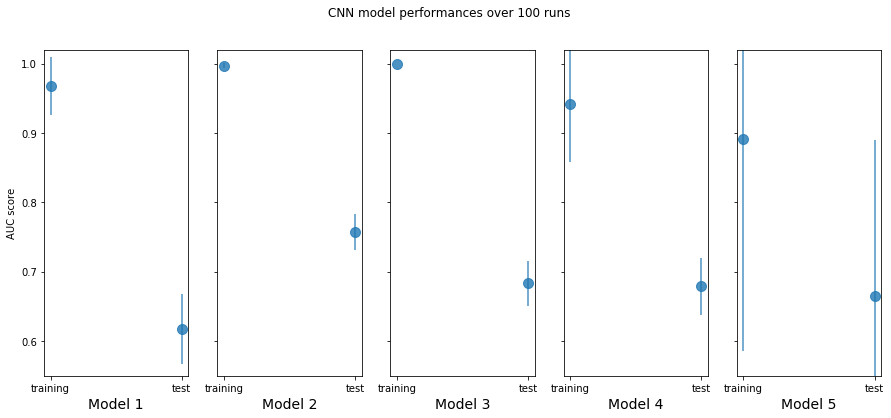

In [8]:
fig, ax = plt.subplots(1,5,sharex=True, sharey=True,figsize= (15,6))
for i in range(num_splits):
    ax[i].errorbar(range(2),medians_CNN[i] ,yerr = iqrs_CNN[i],marker='o', markersize=10, ls='None',alpha=0.8)      
    ax[i].set_xlabel('Model '+str(i+1),size=14)
    ax[i].set_ylim(0.55,1.02)
ax[0].set_ylabel('AUC score')
plt.xticks(range(2),['training','test']) 
plt.suptitle('CNN model performances over 100 runs')
plt.show()
plt.close(fig)

### MLP

In [7]:
medians_MLP = []
iqrs_MLP = []
AUC_MLP = []

for i in range(num_splits):
    AUC_trs_MLP, AUC_tes_MLP = np.loadtxt('../clinical parameter-based/modeling_results/1kplus_multimodal/performance_scores/outer_loop_AUC_performance_over_100_runs_model_'+str(i+1)+'.csv', delimiter=",")

    medians_MLP.append([np.median(AUC_trs_MLP), np.median(AUC_tes_MLP)])
    iqrs_MLP.append([iqr(AUC_trs_MLP),  iqr(AUC_tes_MLP)])
    AUC_MLP.append(AUC_tes_MLP)
    
df_MLP = pd.DataFrame([],columns=multiidx,index = ['median','iqr'])
df_MLP.loc['median',:] = list(matplotlib.cbook.flatten(medians_MLP))
df_MLP.loc['iqr',:] = list(matplotlib.cbook.flatten(iqrs_MLP))


In [10]:
df_MLP

Model 1               Model 2                Model 3             \
         training       test   training       test    training       test   
median   0.809352   0.696605   0.848347   0.760494    0.869926   0.798765   
iqr     0.0490031  0.0537037  0.0111898  0.0243827  0.00394347  0.0111111   

          Model 4               Model 5             
         training       test   training       test  
median   0.822324   0.711728   0.827728    0.77963  
iqr     0.0253223  0.0580247  0.0285251  0.0490741

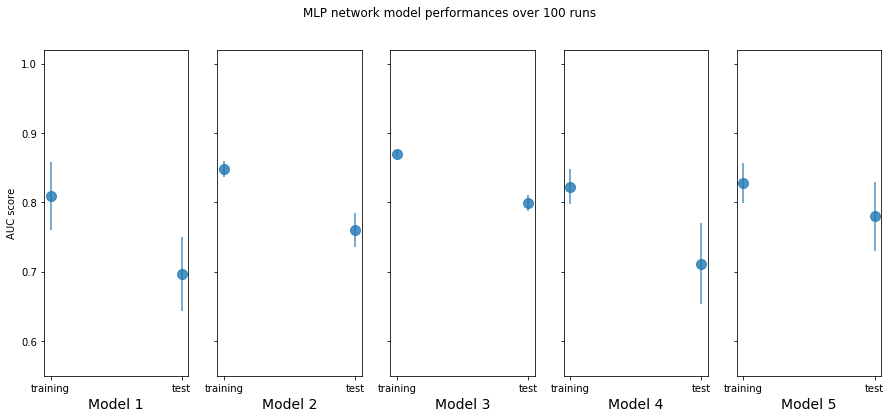

In [11]:
fig, ax = plt.subplots(1,5,sharex=True, sharey=True,figsize= (15,6))
for i in range(num_splits):
    ax[i].errorbar(range(2),medians_MLP[i] ,yerr = iqrs_MLP[i],marker='o', markersize=10, ls='None',alpha=0.8)      
    ax[i].set_xlabel('Model '+str(i+1),size=14)
    ax[i].set_ylim(0.55,1.02)
ax[0].set_ylabel('AUC score')
plt.xticks(range(2),['training','test']) 
plt.suptitle('MLP network model performances over 100 runs')
plt.show()
plt.close(fig)

### End-to-end

In [8]:
medians_end = []
iqrs_end = []
AUC_end = []

for i in range(num_splits):
    AUC_trs_end, AUC_tes_end = np.loadtxt('modeling_results/1kplus_multimodal/performance_scores/end_to_end/outer_loop_AUC_performance_over_100_runs_model_'+str(i+1)+'.csv',delimiter=",")

    medians_end.append([np.median(AUC_trs_end), np.median(AUC_tes_end)])
    iqrs_end.append([iqr(AUC_trs_end),  iqr(AUC_tes_end)])
    AUC_end.append(AUC_tes_end)
    
df_end = pd.DataFrame([],columns=multiidx,index = ['median','iqr'])
df_end.loc['median',:] = list(matplotlib.cbook.flatten(medians_end))
df_end.loc['iqr',:] = list(matplotlib.cbook.flatten(iqrs_end))


In [9]:
df_end

Model 1               Model 2               Model 3             \
         training       test   training       test   training       test   
median   0.898911   0.714815   0.904836   0.778395   0.906358   0.792593   
iqr     0.0565297  0.0364198  0.0700617  0.0225309  0.0612539  0.0268519   

          Model 4              Model 5             
         training      test   training       test  
median   0.922452  0.728395   0.872648   0.808642  
iqr     0.0776483  0.045679  0.0672992  0.0351852

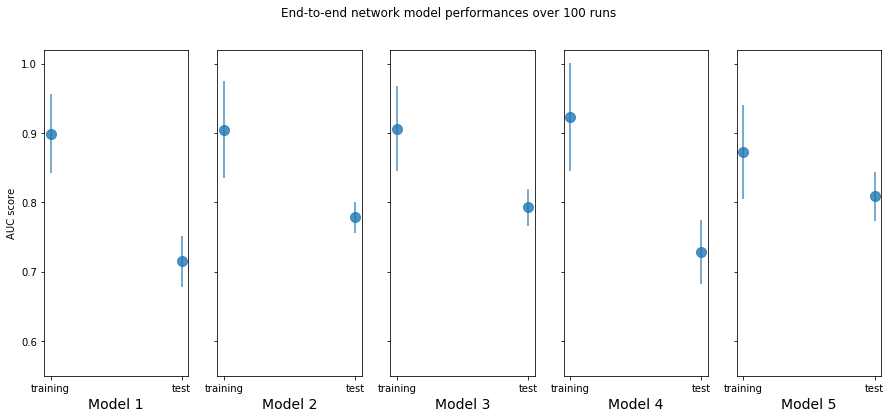

In [14]:
fig, ax = plt.subplots(1,5,sharex=True, sharey=True,figsize= (15,6))
for i in range(num_splits):
    ax[i].errorbar(range(2),medians_end[i] ,yerr = iqrs_end[i],marker='o', markersize=10, ls='None',alpha=0.8)      
    ax[i].set_xlabel('Model '+str(i+1),size=14)
    ax[i].set_ylim(0.55,1.02)
ax[0].set_ylabel('AUC score')
plt.xticks(range(2),['training','test']) 
plt.suptitle('End-to-end network model performances over 100 runs')
plt.show()
plt.close(fig)

### Feature extraction

In [10]:
medians_feat = []
iqrs_feat = []
AUC_feat = []

for i in range(num_splits):
    AUC_trs_feat, AUC_tes_feat = np.loadtxt('modeling_results/1kplus_multimodal/performance_scores/feature_concatenation/outer_loop_AUC_performance_over_100_runs_model_'+str(i+1)+'.csv',delimiter=",")

    medians_feat.append([np.median(AUC_trs_feat), np.median(AUC_tes_feat)])
    iqrs_feat.append([iqr(AUC_trs_feat),  iqr(AUC_tes_feat)])
    AUC_feat.append(AUC_tes_feat)
    
df_feat = pd.DataFrame([],columns=multiidx,index = ['median','iqr'])
df_feat.loc['median',:] = list(matplotlib.cbook.flatten(medians_feat))
df_feat.loc['iqr',:] = list(matplotlib.cbook.flatten(iqrs_feat))




In [16]:
df_feat

Model 1                Model 2              Model 3            \
          training       test    training       test  training      test   
median    0.967611   0.597531    0.955121   0.781481  0.995036  0.780247   
iqr     0.00374329  0.0209877  0.00564497  0.0126543  0.001141  0.016358   

           Model 4                Model 5             
          training       test    training       test  
median     0.87541    0.75679     0.98807   0.834568  
iqr     0.00698615  0.0135802  0.00128113  0.0123457

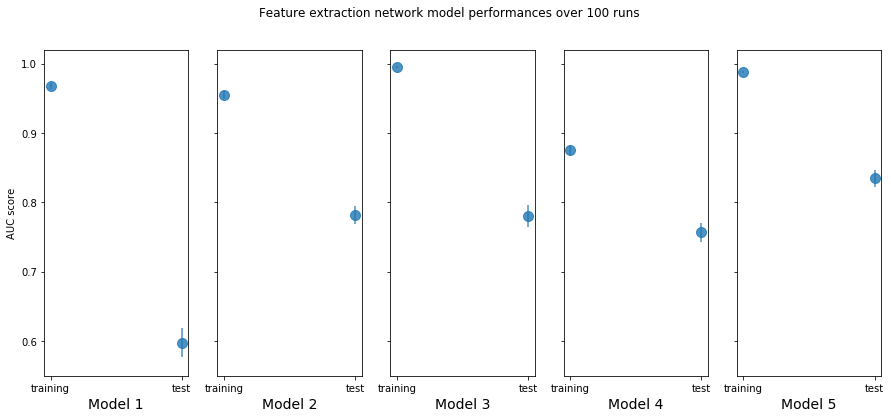

In [17]:
fig, ax = plt.subplots(1,5,sharex=True, sharey=True,figsize= (15,6))
for i in range(num_splits):
    ax[i].errorbar(range(2),medians_feat[i] ,yerr = iqrs_feat[i],marker='o', markersize=10, ls='None',alpha=0.8)      
    ax[i].set_xlabel('Model '+str(i+1),size=14)
    ax[i].set_ylim(0.55,1.02)
ax[0].set_ylabel('AUC score')
plt.xticks(range(2),['training','test']) 
plt.suptitle('Feature extraction network model performances over 100 runs')
plt.show()
plt.close(fig)

### 1.1 Significance test

In [18]:
# Check if Gaussian
from scipy.stats import normaltest
MLP_gaus = []
end_gaus = []
feat_gaus = []

for i in range(num_splits): 
    _, p = normaltest(AUC_MLP[i])
    MLP_gaus.append(p)
    _, p = normaltest(AUC_end[i])
    end_gaus.append(p)
    _, p = normaltest(AUC_feat[i])
    feat_gaus.append(p)

In [20]:
MLP_gaus

[0.0009620972783275808,
 0.2640418806874633,
 0.6253985081447309,
 3.9213820759685565e-07,
 0.13697399662432935]

In [21]:
end_gaus

[3.4343023174175354e-08,
 0.07438325551848347,
 0.06177956276916894,
 0.03414590132157095,
 0.541797388635354]

In [22]:
feat_gaus

[0.3792108208606424,
 0.7360654891210872,
 0.2264845446240076,
 0.15601150877164416,
 0.694448506176382]

#### Non-gaussian except for two models each in MLP and end-to-end

In [23]:
# Wilcoxon
from scipy.stats import wilcoxon
end_MLP = []
feat_MLP = []
end_feat = []

for i in range(num_splits):    
    _, p_val = wilcoxon(AUC_end[i], AUC_MLP[i])
    end_MLP.append(p_val) 
    _, p_val = wilcoxon(AUC_end[i], AUC_feat[i])
    end_feat.append(p_val) 
    _, p_val = wilcoxon(AUC_feat[i], AUC_MLP[i])
    feat_MLP.append(p_val) 
    
#significance = float(format(p_val, '.4f'))

In [24]:
df_sig = pd.DataFrame(np.vstack((end_MLP, feat_MLP, end_feat)), index= ['end-to-end vs. MLP', 'feature extraction vs. MLP',
                      'end-to-end vs. feature extraction'], columns= model_names)

In [25]:
df_sig

,Model 1,Model 2,Model 3,Model 4,Model 5
end-to-end vs. MLP,4.925166e-04,2.980621e-11,4.796815e-03,5.565309e-04,4.254636e-08
feature extraction vs. MLP,6.798112e-18,3.025801e-13,5.852202e-16,4.141138e-16,1.061007e-17
end-to-end vs. feature extraction,4.388961e-18,2.654778e-01,3.109791e-06,7.657110e-12,1.629970e-12


#### Plotting

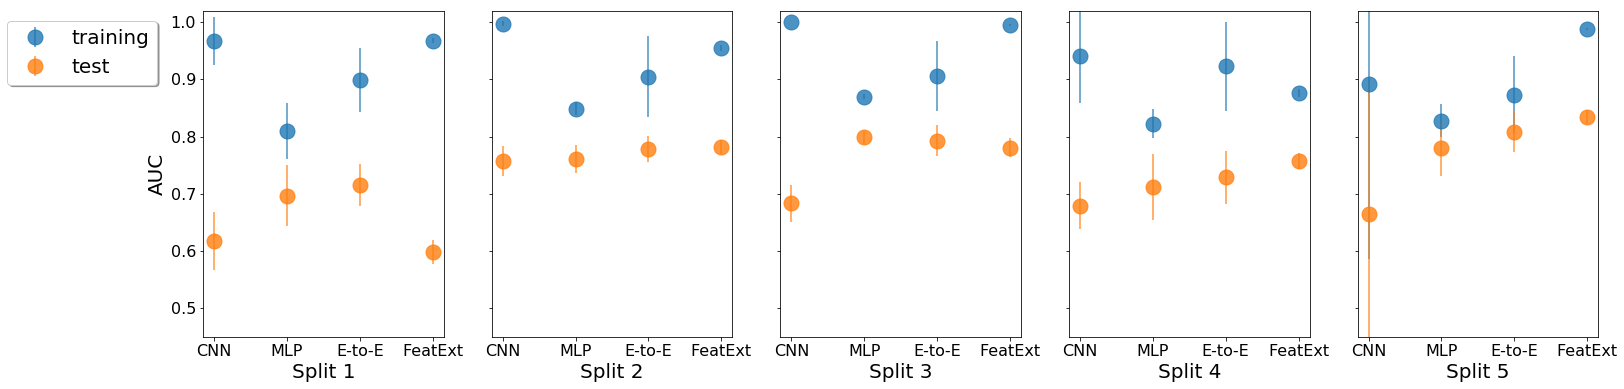

In [28]:
fig, ax = plt.subplots(1,5,sharex=True, sharey=True,figsize= (25,6))
for i in range(num_splits):
    medians_tr = [medians_CNN[i][0],medians_MLP[i][0],medians_end[i][0],medians_feat[i][0]]
    iqrs_tr = [iqrs_CNN[i][0], iqrs_MLP[i][0], iqrs_end[i][0], iqrs_feat[i][0]]
    medians_te = [medians_CNN[i][1],medians_MLP[i][1],medians_end[i][1],medians_feat[i][1]]
    iqrs_te = [iqrs_CNN[i][1], iqrs_MLP[i][1], iqrs_end[i][1], iqrs_feat[i][1]]
    ax[i].errorbar(range(4),medians_tr ,yerr = iqrs_tr,marker='o', markersize=15, ls='None',alpha=0.8,label= 'training')
    ax[i].errorbar(range(4),medians_te ,yerr = iqrs_te,marker='o', markersize=15, ls='None',alpha=0.8,label = 'test')
    ax[i].set_xlabel('Split '+str(i+1),size=20)
    ax[i].set_ylim(0.45,1.02)
    ax[i].tick_params(axis='both', which='major', labelsize=16)
plt.xticks(range(4),['CNN','MLP', 'E-to-E','FeatExt']) 
#plt.suptitle('AUC score distributions',size=21)
ax[0].legend(bbox_to_anchor= (-0.15, 1),shadow=True, prop={'size': 20})
ax[0].set_ylabel('AUC', size=20)
plt.show()
plt.close(fig)

### 2. Variance in performance for the 5 different data splits

In [ ]:
used_params = ['split_1_params','split_2_params','split_3_params','split_4_params','split_5_params']
AUC_types = ['training', 'test']
iterables = [used_params, AUC_types]
multiidx = pd.MultiIndex.from_product(iterables, names = ['Parameters Used','AUC score'])
split_idx = ['split 1 data','split 2 data','split 3 data','split 4 data','split 5 data']

In [23]:
# Imaging (CNN)
df = pd.DataFrame([],columns=multiidx,index = split_idx)
perf = pd.read_csv(img_scores_folder+'final_AUC_performance_all_splits.csv')

In [46]:

for i in range(num_splits):
    with open(img_params_folder+ 'best_tuning_params_split_'+str(i+1)+'.json') as json_file:  
        tuning_params = json.load(json_file)
    df.loc['split '+str(i+1)+' data','split_'+str(i+1)+'_params'] = perf['training AUC'][i], perf['test AUC'][i]
    for j in range(num_splits):
        if not i==j:
            X_tr = img_sets[j]['train_data']
            y_tr = img_sets[j]['train_labels']
            X_val = img_sets[j]['val_data']
            y_val = img_sets[j]['val_labels']
            X_te = img_sets[j]['test_data']
            y_te = img_sets[j]['test_labels']
            X_train = np.concatenate((X_tr,X_val))
            y_train = np.concatenate((y_tr,y_val))
            y_te = pd.get_dummies(y_te)
            y_train = pd.get_dummies(y_train)

            AUC_tr, AUC_te = train_and_evaluate_CNN((X_train,y_train),(X_te,y_te),tuning_params,num_training_runs=1)
            df.loc['split '+str(i+1)+' data','split_'+str(j+1)+'_params'] = AUC_tr[0], AUC_te[0]
            

Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 1 minutes
Training time for run 0 was around 1 minutes
Training time for run 0 was around 1 minutes
Training time for run 0 was around 1 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes
Training time for run 0 was around 0 minutes


In [47]:
df

Parameters Used split_1_params           split_2_params            \
AUC score             training      test       training      test   
split 1 data           0.99944  0.612346       0.986628  0.676543   
split 2 data          0.992393  0.677778       0.995996  0.754321   
split 3 data                 1  0.644444              1  0.738272   
split 4 data          0.821603  0.534568       0.820962   0.72963   
split 5 data           0.99968  0.791358       0.901593  0.707407   

Parameters Used split_3_params           split_4_params            \
AUC score             training      test       training      test   
split 1 data          0.979502  0.706173       0.912803  0.646914   
split 2 data           0.99952  0.696296       0.989431  0.702469   
split 3 data                 1  0.667901              1  0.682716   
split 4 data          0.989911   0.72963       0.879334  0.658025   
split 5 data               0.5       0.5            0.5       0.5   

Parameters Used split_5_params            
AUC score             training      test  
split 1 data          0.995596  0.740741  
split 2 data          0.995196  0.791358  
split 3 data                 1   0.67284  
split 4 data          0.960365  0.758025  
split 5 data          0.790536       0.6

In [52]:
df_means = [list(df.loc[:,'split_'+str(i+1)+'_params'].mean()) for i in range(num_splits)]
df_stds = [list(df.loc[:,'split_'+str(i+1)+'_params'].std()) for i in range(num_splits)]

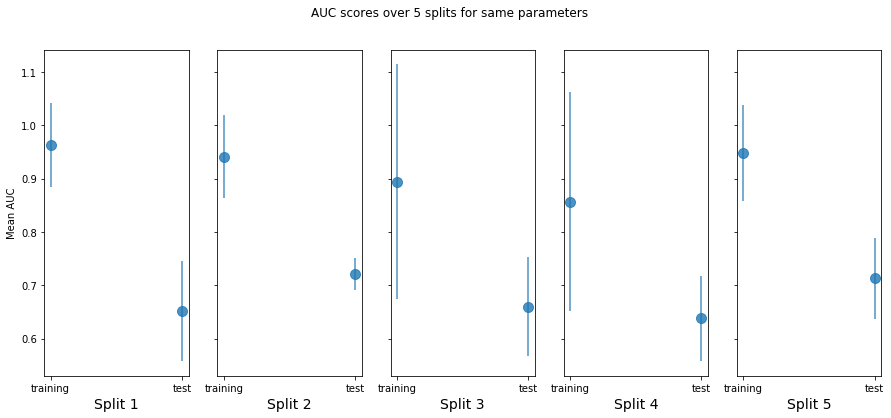

In [56]:
fig, ax = plt.subplots(1,5,sharex=True, sharey=True,figsize= (15,6))
for i in range(num_splits):
    ax[i].errorbar(range(2),df_means[i] ,yerr = df_stds[i],marker='o', markersize=10, ls='None',alpha=0.8)      
    ax[i].set_xlabel('Split '+str(i+1),size=14)
ax[0].set_ylabel('Mean AUC')
plt.xticks(range(2),['training','test']) 
plt.suptitle('AUC scores over 5 splits for same parameters')
plt.show()
plt.close(fig)

In [57]:
# Clinical(MLP)
df_clin = pd.DataFrame([],columns=multiidx,index = split_idx)

In [59]:
for i in range(num_splits):
    with open(clin_params_folder+ 'best_MLP_multimodal_tuning_parameters_run_'+str(i+1)+'_softmax.json') as json_file:  
        tuning_params = json.load(json_file)
    perf = np.loadtxt(clin_scores_folder+ 'final_performance_auc_scores_'+str(i+1)+'_softmax.csv',delimiter=',')
    df_clin.loc['split '+str(i+1)+' data','split_'+str(i+1)+'_params'] = perf[0], perf[1]
    for j in range(num_splits):
        if not i==j:
            X_tr = clin_sets[j]['train_data']
            y_tr = clin_sets[j]['train_labels']
            X_val = clin_sets[j]['val_data']
            y_val = clin_sets[j]['val_labels']
            X_te = clin_sets[j]['test_data']
            y_te = clin_sets[j]['test_labels']
            X_train = np.concatenate((X_tr,X_val))
            y_train = np.concatenate((y_tr,y_val))
            y_te = pd.get_dummies(y_te)
            y_train = pd.get_dummies(y_train.reshape(250,))

            AUC_tr, AUC_te = train_and_evaluate_MLP((X_train,y_train),(X_te,y_te),tuning_params,num_training_runs=1)
            df_clin.loc['split '+str(i+1)+' data','split_'+str(j+1)+'_params'] = AUC_tr[0], AUC_te[0]
            

[0.76739531 0.70771605]
[0.872728   0.77901235]
[0.87080631 0.80617284]
[0.76655457 0.69012346]
[0.81015293 0.80864198]


In [60]:
df_clin

Parameters Used split_1_params           split_2_params            \
AUC score             training      test       training      test   
split 1 data          0.767395  0.707716       0.755745  0.783951   
split 2 data          0.869085  0.735185       0.872728  0.779012   
split 3 data          0.878373  0.738889       0.883778  0.790123   
split 4 data          0.808471  0.717901       0.837337  0.782716   
split 5 data           0.85267  0.788272       0.801065  0.666667   

Parameters Used split_3_params           split_4_params            \
AUC score             training      test       training      test   
split 1 data          0.794739  0.801235       0.742533  0.579012   
split 2 data          0.838938  0.788889       0.871727  0.740741   
split 3 data          0.870806  0.806173       0.873208  0.769136   
split 4 data          0.817159  0.781481       0.766555  0.690123   
split 5 data          0.803707  0.798765       0.743334  0.679012   

Parameters Used split_5_params            
AUC score             training      test  
split 1 data          0.774842  0.776543  
split 2 data          0.869005  0.788889  
split 3 data          0.882857  0.809877  
split 4 data          0.827929  0.785185  
split 5 data          0.810153  0.808642

In [61]:
df_clin_means = [list(df_clin.loc[:,'split_'+str(i+1)+'_params'].mean()) for i in range(num_splits)]
df_clin_stds = [list(df_clin.loc[:,'split_'+str(i+1)+'_params'].std()) for i in range(num_splits)]

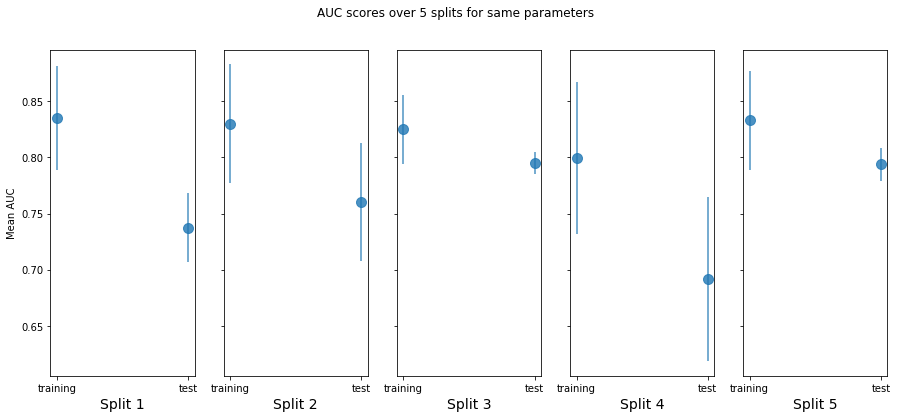

In [62]:
fig, ax = plt.subplots(1,5,sharex=True, sharey=True,figsize= (15,6))
for i in range(num_splits):
    ax[i].errorbar(range(2),df_clin_means[i] ,yerr = df_clin_stds[i],marker='o', markersize=10, ls='None',alpha=0.8)      
    ax[i].set_xlabel('Split '+str(i+1),size=14)
ax[0].set_ylabel('Mean AUC')
plt.xticks(range(2),['training','test']) 
plt.suptitle('AUC scores over 5 splits for same parameters')
plt.show()
plt.close(fig)

### 3. Variance in inner and outer loop performance scores

In [4]:
splits = ['split_1','split_2','split_3','split_4','split_5']
AUC_types = ['training AUC', 'validation AUC','test AUC']
loops = ['inner loop', 'outer loop']
iterables = [splits, loops]
multiidx = pd.MultiIndex.from_product(iterables, names = ['Splits','Loops'])


In [11]:
# Imaging (CNN)
df_loop = pd.DataFrame([],columns=multiidx,index = AUC_types)
perf = pd.read_csv(img_scores_folder+'final_AUC_performance_all_splits.csv')
inner_perf =  pd.read_csv(img_scores_folder+'inner_loop_AUC_performance_all_splits.csv')

In [12]:
for i in range(num_splits):
    df_loop.loc['training AUC','split_'+str(i+1)]['outer loop'] = perf['training AUC'][i]
    df_loop.loc['validation AUC','split_'+str(i+1)]['outer loop'] = ''
    df_loop.loc['test AUC','split_'+str(i+1)]['outer loop'] = perf['test AUC'][i]
    df_loop.loc['training AUC','split_'+str(i+1)]['inner loop'] = inner_perf['training AUC'][i]
    df_loop.loc['validation AUC','split_'+str(i+1)]['inner loop'] = inner_perf['validation AUC'][i]
    df_loop.loc['test AUC','split_'+str(i+1)]['inner loop'] = inner_perf['test AUC'][i]

In [13]:
df_loop

Splits            split_1               split_2               split_3  \
Loops          inner loop outer loop inner loop outer loop inner loop   
training AUC     0.995298    0.99944   0.992038   0.995996          1   
validation AUC   0.855159              0.650794              0.826389   
test AUC         0.580864   0.612346   0.737037   0.754321    0.67963   

Splits                       split_4               split_5             
Loops          outer loop inner loop outer loop inner loop outer loop  
training AUC            1   0.882257   0.879334          1   0.790536  
validation AUC              0.914683              0.784722             
test AUC         0.667901   0.650617   0.658025   0.774691        0.6

In [18]:
# Clinical(MLP)
df_clin_loop = pd.DataFrame([],columns=multiidx,index = AUC_types)

In [19]:
for i in range(num_splits):
    perf = np.loadtxt(clin_scores_folder+ 'final_performance_auc_scores_'+str(i+1)+'_softmax.csv',delimiter=',')
    inner_perf = np.loadtxt(clin_scores_folder+ 'best_gridsearch_loss_and_AUC_over_epochs_'+str(i+1)+'_softmax.csv',delimiter=',')
    df_clin_loop.loc['training AUC','split_'+str(i+1)]['outer loop'] = perf[0]
    df_clin_loop.loc['validation AUC','split_'+str(i+1)]['outer loop'] = ''
    df_clin_loop.loc['test AUC','split_'+str(i+1)]['outer loop'] = perf[1]
    df_clin_loop.loc['training AUC','split_'+str(i+1)]['inner loop'] = inner_perf[0,-1]
    df_clin_loop.loc['validation AUC','split_'+str(i+1)]['inner loop'] = inner_perf[1,-1]
    df_clin_loop.loc['test AUC','split_'+str(i+1)]['inner loop'] = inner_perf[2,-1]
    

In [20]:
df_clin_loop

Splits            split_1               split_2               split_3  \
Loops          inner loop outer loop inner loop outer loop inner loop   
training AUC     0.794734   0.767395   0.847649   0.872728   0.857743   
validation AUC   0.936508              0.837302              0.981151   
test AUC         0.700309   0.707716   0.777778   0.779012    0.77037   

Splits                       split_4               split_5             
Loops          outer loop inner loop outer loop inner loop outer loop  
training AUC     0.870806   0.870596   0.766555   0.826082   0.810153  
validation AUC              0.892857              0.890873             
test AUC         0.806173   0.732099   0.690123   0.780247   0.808642

In [10]:
# Combined model (MLP)
df_comb_loop = pd.DataFrame([],columns=multiidx,index = AUC_types)
save_scores = cfg['save options']['scores path']
save_params = cfg['save options']['params path']

In [11]:
for i in range(num_splits):
    perf = np.loadtxt(save_scores+ '/final_performance_auc_scores_'+str(i+1)+'.csv',delimiter=',')
    inner_perf = np.loadtxt(save_scores+ '/inner_loop_loss_and_AUC_over_epochs_'+str(i+1)+'_softmax.csv',delimiter=',')
    df_comb_loop.loc['training AUC','split_'+str(i+1)]['outer loop'] = perf[0]
    df_comb_loop.loc['validation AUC','split_'+str(i+1)]['outer loop'] = ''
    df_comb_loop.loc['test AUC','split_'+str(i+1)]['outer loop'] = perf[1]
    df_comb_loop.loc['training AUC','split_'+str(i+1)]['inner loop'] = inner_perf[0,-1]
    df_comb_loop.loc['validation AUC','split_'+str(i+1)]['inner loop'] = inner_perf[1,-1]
    df_comb_loop.loc['test AUC','split_'+str(i+1)]['inner loop'] = inner_perf[2,-1]
    

In [12]:
df_comb_loop

Splits            split_1               split_2               split_3  \
Loops          inner loop outer loop inner loop outer loop inner loop   
training AUC            1     0.9996          1   0.992634          1   
validation AUC          1                     1                     1   
test AUC         0.662963   0.641975   0.748148   0.758025   0.703704   

Splits                       split_4               split_5             
Loops          outer loop inner loop outer loop inner loop outer loop  
training AUC      0.99968    0.91511   0.902634   0.966771   0.896709  
validation AUC              0.972222              0.890873             
test AUC         0.674074   0.692593   0.718519   0.712346   0.665432

### 4. Change in performance with increasing sample size

##### Notes: For this analysis the whole dataset was used for training gradually. There is no validation or test set defined, thus early stopping criteria can not be defined either since it's defined by validation loss. For this reason epoch count was decreased to 10 in order to prevent training AUC from converging to 1. 

In [ ]:
# Imaging (CNN)
data.load_data(dataset_path, labels_path)

In [ ]:
AUC_trs = []
for i in np.arange(100,data.X.shape[0]+1):
    X_tr = data.X[:i]
    y_tr = data.y[:i]
    y_tr = pd.get_dummies(y_tr)
    model = Sequential()
    model.add(Conv3D(num_filters[0], filter_size, strides = filter_stride,padding="same",kernel_regularizer= keras.regularizers.l2(l2_reg),input_shape=(156,192,64,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size= pool_size))

    model.add(Conv3D(num_filters[1], filter_size, strides = filter_stride,padding="same",kernel_regularizer= keras.regularizers.l2(l2_reg) ))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=pool_size))

    model.add(Conv3D(num_filters[2], filter_size, strides = filter_stride,padding="same",kernel_regularizer= keras.regularizers.l2(l2_reg)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=pool_size))

    model.add(Flatten())
    model.add(Dense(num_neurons, activation='relu',kernel_regularizer= keras.regularizers.l2(l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(2 , activation='softmax'))

    optimizer = keras.optimizers.Adam(lr = lr)

    model.compile(loss='binary_crossentropy',optimizer=optimizer)

    parallel_model = multi_gpu_model(model, 2)
    parallel_model.compile(loss='binary_crossentropy',optimizer=optimizer)

    start = time.time()
    history = parallel_model.fit(X_train, y_train, 
                                 batch_size = batch_size, epochs=10,verbose = 0)
    end = time.time()

    model.set_weights(parallel_model.get_weights())
    
    probs_tr = model.predict(X_train, batch_size = 8)
    score_tr = roc_auc_score(y_train, probs_tr)   
    AUC_trs.append(score_tr)

    print('Training time for run %i was around %i minutes'%(i, np.floor((end-start)/60)))
    

In [ ]:
fig = plt.figure()
plt.plot(np.arange(100,data.X.shape[0]+1),AUC_trs, 'g-')
plt.xlabel('number of data points')
plt.ylabel('training AUC')
plt.show()
plt.close(fig)